
**Install requirements**

In [43]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.4.2'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
import copy
import pdb

import matplotlib.pyplot as plt

import torchvision
from torchvision import transforms
from torchvision.models import alexnet
from torch.autograd import Function

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'



BATCH_SIZE = 64     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 1e-2        # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down
ALPHA = 0.01
LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalizes tensor with mean and standard deviation
])

**DANN**

In [0]:
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url


model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth',
}

class ReverseLayerF(Function):
    # Forwards identity
    # Sends backward reversed gradients
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class DANN(nn.Module):

    def __init__(self, num_classes=1000):
        super(DANN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.class_classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        #carico il modello
        state_dict = load_state_dict_from_url(model_urls['alexnet'])
        self.load_state_dict(state_dict = state_dict,strict=False)
        self.domain_classifier = copy.deepcopy(self.class_classifier)
        self.domain_classifier[6].out_features = 2


    def forward(self,input_data,alpha):
        
        feature = self.features(input_data)
        feature = self.avgpool(feature)
        feature = torch.flatten(feature, 1)
        if alpha is not None:
            # gradient reversal layer (backward gradients will be reversed)
            reverse_feature = ReverseLayerF.apply(feature, alpha)
            discriminator_output = self.domain_classifier(reverse_feature)
            return discriminator_output
        # If we don't pass alpha, we assume we are training with supervision
        else:
            # do something else
            class_outputs = self.class_classifier(feature)
            return class_outputs
  


**Import Dataset**

In [0]:
# Clone github repository with data
if not os.path.isdir('./Homework3-PACS'):
  !git clone https://github.com/MachineLearning2020/Homework3-PACS.git

DATA_DIR = 'Homework3-PACS/PACS/'

# Prepare Pytorch train/test Datasets
photo_dataset = torchvision.datasets.ImageFolder(DATA_DIR+'photo', transform=train_transform)
art_dataset = torchvision.datasets.ImageFolder(DATA_DIR+'art_painting', transform=train_transform)
sketch_dataset = torchvision.datasets.ImageFolder(DATA_DIR+'sketch', transform=train_transform)
cartoon_dataset = torchvision.datasets.ImageFolder(DATA_DIR+'cartoon', transform=train_transform)



# Check dataset size
#print('Source Dataset: {}'.format(len(source_dataset)))
#print('Target Dataset: {}'.format(len(target_dataset)))

**Grid search no Domain adaptation**

In [49]:
'''
#paramiters for grid search
lr = [1e-3,1e-2,1e-1]
batch_size = [64,128,256]
best_lr = 0
best_batch_size = 0
best_accuracy = 0


for l in lr:
  for b in batch_size:

    source_dataloader = DataLoader(photo_dataset, batch_size=b, shuffle=True, num_workers=4, drop_last=True)
    target_dataloader_1 = DataLoader(cartoon_dataset, batch_size=b, shuffle=True, num_workers=4, drop_last=True)
    target_dataloader_2 = DataLoader(sketch_dataset, batch_size=b, shuffle=True, num_workers=4, drop_last=True)

      

    net_1 = DANN() # Loading DANN
    net_2 = DANN()
    # 7 classes of PACS
    net_1.class_classifier[6] = nn.Linear(4096, 7)
    net_2.class_classifier[6] = nn.Linear(4096, 7)


    optimizer_1 = optim.SGD(net_1.parameters(), lr=l, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    optimizer_2 = optim.SGD(net_2.parameters(), lr=l, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

    loss_class = nn.CrossEntropyLoss()

    net_1 = net_1.cuda()
    net_2 = net_2.cuda()
    loss_class = loss_class.cuda()

    for p in net_1.parameters():
        p.requires_grad = True
    for p in net_2.parameters():
      p.requires_grad = True

      # By default, everything is loaded to cpu
    net_1 = net_1.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
    net_2 = net_2.to(DEVICE)
    cudnn.benchmark # Calling this optimizes runtime
      
    num_epochs = 5
      # Start iterating over the epochs
    for epoch in range(num_epochs):
      # Train model with source data
      for images, labels in source_dataloader:

      # Bring data over the device of choice
        optimizer_1.zero_grad() # Zero-ing the gradients
        optimizer_2.zero_grad()

        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        #Train classifier
        class_output_1 = net_1(input_data=images,alpha = None)
        class_output_2 = net_2(input_data=images,alpha = None)
        err_s_label_1 = loss_class(class_output_1, labels)
        err_s_label_2 = loss_class(class_output_2, labels)
        err_s_label_1.backward()
        err_s_label_2.backward()
        optimizer_1.step()
        optimizer_2.step()

          
      #Validate model
      net_1.train(False)
      net_2.train(False)

      running_corrects = 0
      for images, labels in tqdm(target_dataloader_1):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        labels_domain = torch.ones(len(labels)).to(DEVICE)
        # Forward Pass
        outputs = net_1(images,alpha = None)
        # Get predictions
        _, preds = torch.max(outputs.data, 1)
        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()
      accuracy_1 = running_corrects / float(len(cartoon_dataset))

      running_corrects = 0
      for images, labels in tqdm(target_dataloader_2):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        labels_domain = torch.ones(len(labels)).to(DEVICE)
        # Forward Pass
        outputs = net_2(images,alpha = None)
        # Get predictions
        _, preds = torch.max(outputs.data, 1)
        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()
      accuracy_2 = running_corrects / float(len(sketch_dataset))
      
      accuracy = (accuracy_1 + accuracy_2)/2
      if(best_accuracy < accuracy):
        best_accuracy = accuracy
        best_lr = l
        best_batch_size = b

LR = best_lr
BATCH_SIZE = best_batch_size

print("LR %f",LR)
print("BATCH_SIZE",BATCH_SIZE)
print("Accuracy %f",best_accuracy)
'''



'\n#paramiters for grid search\nlr = [1e-3,1e-2,1e-1]\nbatch_size = [64,128,256]\nbest_lr = 0\nbest_batch_size = 0\nbest_accuracy = 0\n\n\nfor l in lr:\n  for b in batch_size:\n\n    source_dataloader = DataLoader(photo_dataset, batch_size=b, shuffle=True, num_workers=4, drop_last=True)\n    target_dataloader_1 = DataLoader(cartoon_dataset, batch_size=b, shuffle=True, num_workers=4, drop_last=True)\n    target_dataloader_2 = DataLoader(sketch_dataset, batch_size=b, shuffle=True, num_workers=4, drop_last=True)\n\n      \n\n    net_1 = DANN() # Loading DANN\n    net_2 = DANN()\n    # 7 classes of PACS\n    net_1.class_classifier[6] = nn.Linear(4096, 7)\n    net_2.class_classifier[6] = nn.Linear(4096, 7)\n\n\n    optimizer_1 = optim.SGD(net_1.parameters(), lr=l, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)\n    optimizer_2 = optim.SGD(net_2.parameters(), lr=l, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)\n\n    loss_class = nn.CrossEntropyLoss()\n\n    net_1 = net_1.cuda()\n    net_2 = 

**Grid search**

In [50]:
'''
#paramiters for grid search
lr = [1e-3,1e-2,1e-1]
alpha =[1e-2,1e-1,1]
batch_size = [64,128,256]
best_lr = 0
best_alpha = 0
best_batch_size = 0
best_accuracy = 0


for l in lr:
  for a in alpha:
    for b in batch_size:

      source_dataloader = DataLoader(photo_dataset, batch_size=b, shuffle=True, num_workers=4, drop_last=True)
      target_dataloader_1 = DataLoader(cartoon_dataset, batch_size=b, shuffle=True, num_workers=4, drop_last=True)
      target_dataloader_2 = DataLoader(sketch_dataset, batch_size=b, shuffle=True, num_workers=4, drop_last=True)
      

      net_1 = DANN() # Loading DANN
      net_2 = DANN()
      # 7 classes of PACS
      net_1.class_classifier[6] = nn.Linear(4096, 7) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d
      net_2.class_classifier[6] = nn.Linear(4096, 7)                                         

      optimizer_1 = optim.SGD(net_1.parameters(), lr=l, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
      optimizer_2 = optim.SGD(net_2.parameters(), lr=l, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

      loss_class = nn.CrossEntropyLoss()
      loss_domain = nn.CrossEntropyLoss()

      net_1 = net_1.cuda()
      net_2 = net_2.cuda()

      loss_class = loss_class.cuda()
      loss_domain = loss_domain.cuda()

      for p in net_1.parameters():
        p.requires_grad = True
      for p in net_2.parameters():
        p.requires_grad = True

      # By default, everything is loaded to cpu
      net_1 = net_1.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
      net_2 = net_2.to(DEVICE)
      cudnn.benchmark # Calling this optimizes runtime
      
      num_epochs = 5
      # Start iterating over the epochs
      for epoch in range(num_epochs):
        # Train model with source data
        iter_target = iter(target_dataloader_1)
        for xs,ys in source_dataloader:
          net_1.zero_grad()
          try:
            xt,yt = next(iter_target)
          except:
          #if i finish target data i restart iteration over them to finish source data
            iter_target = iter(target_dataloader_1)
            xt,yt = next(iter_target)
          
          
          xs = xs.to(DEVICE)
          ys = ys.to(DEVICE)
          xt = xt.to(DEVICE)
          ysd = torch.zeros(b).long().to(DEVICE)
          yt = torch.ones(b).long().to(DEVICE)
      
          #Train classifier
          class_output = net_1(input_data=xs,alpha = None)
          err_s_label = loss_class(class_output, ys)
          err_s_label.backward()

          #Train discriminator source data
          domain_output = net_1(input_data=xs,alpha=a)
          err_s_domain = loss_domain(domain_output, ysd)
          err_s_domain.backward()

          #Train discriminator target data
          domain_output = net_1(input_data=xt,alpha=a)
          err_t_domain = loss_domain(domain_output,yt)
          err_t_domain.backward()
    
          optimizer_1.step()

        iter_target = iter(target_dataloader_2)
          
        for xs,ys in source_dataloader:
          net_2.zero_grad()
          try:
            xt,yt = next(iter_target)
          except:
          #if i finish target data i restart iteration over them to finish source data
            iter_target = iter(target_dataloader_2)
            xt,yt = next(iter_target)
          
          
          xs = xs.to(DEVICE)
          ys = ys.to(DEVICE)
          xt = xt.to(DEVICE)
          ysd = torch.zeros(b).long().to(DEVICE)
          yt = torch.ones(b).long().to(DEVICE)
      
          #Train classifier
          class_output = net_2(input_data=xs,alpha = None)
          err_s_label = loss_class(class_output, ys)
          err_s_label.backward()

          #Train discriminator source data
          domain_output = net_2(input_data=xs,alpha=a)
          err_s_domain = loss_domain(domain_output, ysd)
          err_s_domain.backward()

          #Train discriminator target data
          domain_output = net_2(input_data=xt,alpha=a)
          err_t_domain = loss_domain(domain_output,yt)
          err_t_domain.backward()
    
          optimizer_2.step()    
      #Validate model
      net_1.train(False)
      net_2.train(False)

      running_corrects = 0
      for images, labels in tqdm(target_dataloader_1):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        # Forward Pass
        outputs = net_1(images,alpha = None)
        # Get predictions
        _, preds = torch.max(outputs.data, 1)
        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()
      accuracy_1 = running_corrects / float(len(cartoon_dataset))

      running_corrects = 0
      for images, labels in tqdm(target_dataloader_2):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        # Forward Pass
        outputs = net_2(images,alpha = None)
        # Get predictions
        _, preds = torch.max(outputs.data, 1)
        # Update Corrects
        running_corrects += torch.sum(preds == labels.data).data.item()
      accuracy_2 = running_corrects / float(len(sketch_dataset))

      accuracy = (accuracy_1 + accuracy_2)/2

      if(best_accuracy < accuracy):
        best_accuracy = accuracy
        best_lr = l
        best_alpha = a
        best_batch_size = b

LR = best_lr
ALPHA = best_alpha
BATCH_SIZE = best_batch_size

print("LR %f",LR)
print("ALPHA %f",ALPHA)
print("BATCH_SIZE",BATCH_SIZE)
print("Accuracy %f",best_accuracy)
'''

'\n#paramiters for grid search\nlr = [1e-3,1e-2,1e-1]\nalpha =[1e-2,1e-1,1]\nbatch_size = [64,128,256]\nbest_lr = 0\nbest_alpha = 0\nbest_batch_size = 0\nbest_accuracy = 0\n\n\nfor l in lr:\n  for a in alpha:\n    for b in batch_size:\n\n      source_dataloader = DataLoader(photo_dataset, batch_size=b, shuffle=True, num_workers=4, drop_last=True)\n      target_dataloader_1 = DataLoader(cartoon_dataset, batch_size=b, shuffle=True, num_workers=4, drop_last=True)\n      target_dataloader_2 = DataLoader(sketch_dataset, batch_size=b, shuffle=True, num_workers=4, drop_last=True)\n      \n\n      net_1 = DANN() # Loading DANN\n      net_2 = DANN()\n      # 7 classes of PACS\n      net_1.class_classifier[6] = nn.Linear(4096, 7) # nn.Linear in pytorch is a fully connected layer\n                                                 # The convolutional layer is nn.Conv2d\n      net_2.class_classifier[6] = nn.Linear(4096, 7)                                         \n\n      optimizer_1 = optim.SGD(net

**Train no domain adaptation**

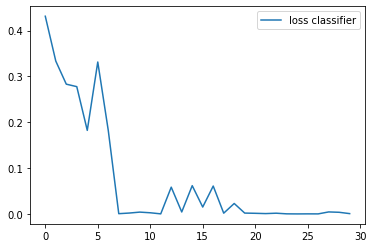

In [51]:

#Use of epochs validation splitting target dataset


source_dataloader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=4, drop_last=True)
target_dataloader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

net = DANN() # Loading DANN
# 7 classes of PACS
net.class_classifier[6] = nn.Linear(4096, 7) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

loss_class = nn.CrossEntropyLoss()

net = net.cuda()
loss_class = loss_class.cuda()

for p in net.parameters():
    p.requires_grad = True

# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

loss_classifier_list = []
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  # Train model with source data
  for images, labels in source_dataloader:
    # Bring data over the device of choice
    optimizer.zero_grad() # Zero-ing the gradients
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    #Train classifier
    optimizer.zero_grad()
    class_output = net(input_data=images,alpha = None)
    err_s_label = loss_class(class_output, labels)
    err_s_label.backward()
    optimizer.step()
  loss_classifier_list.append(err_s_label)

 
epochs =[i for i in range(NUM_EPOCHS)]
plt.plot(epochs,loss_classifier_list,label = 'loss classifier')
plt.legend()
plt.show()


**Train**

In [52]:
'''
#Use of epochs validation splitting target dataset



source_dataloader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=4, drop_last=True)
target_dataloader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)



net = DANN() # Loading DANN
# 7 classes of PACS
net.class_classifier[6] = nn.Linear(4096, 7) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

                                                

optimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

for p in net.parameters():
    p.requires_grad = True 

loss_class = nn.CrossEntropyLoss()
loss_domain = nn.CrossEntropyLoss()

net = net.cuda()
loss_class = loss_class.cuda()
loss_domain = loss_domain.cuda()



# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

loss_classifier_list = []
loss_s_domain_list = []
loss_t_domain_list = []
best_accuracy = 0
best_net = None


# Start iterating over the epochs

for epoch in range(NUM_EPOCHS):
  # Train model with source data
  iter_target = iter(target_dataloader)


  for xs,ys in source_dataloader:
    net.zero_grad()
    try:
      xt,yt = next(iter_target)
    except:
      #if i finish target data i restart iteration over them to finish source data
      iter_target = iter(target_dataloader)
      xt,yt = next(iter_target)
    
    xs = xs.to(DEVICE)
    ys = ys.to(DEVICE)
    xt = xt.to(DEVICE)
    ysd = torch.zeros(BATCH_SIZE).long().to(DEVICE)
    yt = torch.ones(BATCH_SIZE).long().to(DEVICE)
      
    #Train classifier
    class_output = net(input_data=xs,alpha = None)
    err_s_label = loss_class(class_output, ys)
    err_s_label.backward()

    #Train discriminator source data
    domain_output = net(input_data=xs,alpha=ALPHA)
    err_s_domain = loss_domain(domain_output, ysd)
    err_s_domain.backward()

    #Train discriminator target data
    domain_output = net(input_data=xt,alpha=ALPHA)
    err_t_domain = loss_domain(domain_output,yt)
    err_t_domain.backward()

    optimizer.step()
  loss_s_domain_list.append(err_s_domain.item())
  loss_classifier_list.append(err_s_label.item())
  loss_t_domain_list.append(err_t_domain.item())
   
epochs =[i for i in range(NUM_EPOCHS)]
plt.plot(epochs,loss_s_domain_list,label = 'loss source domain')
plt.plot(epochs,loss_t_domain_list,label = 'loss target domain')
plt.plot(epochs,loss_classifier_list,label = 'loss classifier')
plt.legend()
plt.show()

'''
 


"\n#Use of epochs validation splitting target dataset\n\n\n\nsource_dataloader = DataLoader(photo_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=4, drop_last=True)\ntarget_dataloader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)\n\n\n\nnet = DANN() # Loading DANN\n# 7 classes of PACS\nnet.class_classifier[6] = nn.Linear(4096, 7) # nn.Linear in pytorch is a fully connected layer\n                                                 # The convolutional layer is nn.Conv2d\n\n                                                \n\noptimizer = optim.SGD(net.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)\n\nfor p in net.parameters():\n    p.requires_grad = True \n\nloss_class = nn.CrossEntropyLoss()\nloss_domain = nn.CrossEntropyLoss()\n\nnet = net.cuda()\nloss_class = loss_class.cuda()\nloss_domain = loss_domain.cuda()\n\n\n\n# By default, everything is loaded to cpu\nnet = net.to(DEVICE) # this will bring the network to 

**Test**

In [53]:

target_dataloader = DataLoader(art_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(target_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)


  # Forward Pass
  outputs = net(images,alpha = None)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()


# Calculate Accuracy
accuracy = running_corrects / float(len(art_dataset))

print('Test Accuracy classification: {}'.format(accuracy))



100%|██████████| 32/32 [00:06<00:00,  4.74it/s]

Test Accuracy classification: 0.4833984375
